# Master Equation Solver: Single-Qubit Dynamics

Authors: J.R. Johansson and P.D. Nation

Modified by: C. Staufebiel (2022)

### Introduction
In this notebook we will explore the dynamics of a single-qubit interacting with an environment. The evolution of the qubit state is governed by the Master equation. We will make use of the master equation solver `qutip.mesolve` implemented in qutip, to obtain the time-evolution of the qubit for different settings.

You can read more about the master equation solver (and the theory behind it) in the [QuTiP docs](https://qutip.org/docs/latest/apidoc/functions.html?highlight=sesolve#module-qutip.sesolve).

### Import
Here we import the required modules for this example.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import expect, Bloch, Bloch3d, about, basis, mesolve, sigmam, sigmap, sigmax, sigmay, sigmaz, qeye

%matplotlib inline

### Helpful functions

Define
`add_evolving_states(self, states)`
and
`animate_bloch(states, filename='', duration=0.1)`

In [19]:
def _(self, states, kind='point', vector=True):
    """
    Add a curve representing the evolution of a state.
    Evolution: green → yellow.
    """
    import matplotlib
    length = len(states)
    nrm = matplotlib.colors.Normalize(0,length)
    colors = matplotlib.cm.summer(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    # Customize sphere properties
    self.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    self.point_marker = ['o']
    self.point_size = [30]

    if kind == 'point':
        # Use the line below to add states as points
        self.add_states(states, kind='point')
    elif kind == 'arc':
        # Use the line below to add states as arcs
        for i in range(len(states) - 1):
            self.add_arc(states[i], states[i+1], color=colors[i], fmt='')
    elif kind == 'line':
        for i in range(len(states) - 1):
            self.add_line(states[i], states[i+1], color=colors[i], fmt='')
    else:
        raise Exception('Wrong kind. Allowed kinds: point, arc, line.')
    
    if vector:
        self.vector_color = [colors[0], colors[-1]]
        self.add_states(states[0])
        self.add_states(states[-1])
Bloch.add_evolving_states = _

In [59]:
def _(self, states, kind='point', vector=True):
    """
    Add a curve representing the evolution of a state.
    Evolution: green → yellow.
    """
    import matplotlib
    length = len(states)
    nrm = matplotlib.colors.Normalize(0,length)
    colors = matplotlib.cm.summer(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    # # Customize sphere properties
    self.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    # self.point_marker = ['o']
    self.point_size = 0.05

    if kind == 'point':
        # Use the line below to add states as points
        self.add_states(states, kind='point')
    # elif kind == 'arc':
    #     # Use the line below to add states as arcs
    #     for i in range(len(states) - 1):
    #         self.add_arc(states[i], states[i+1], color=colors[i], fmt='')
    # elif kind == 'line':
    #     for i in range(len(states) - 1):
    #         self.add_line(states[i], states[i+1], color=colors[i], fmt='')
    else:
        raise Exception('Wrong kind. Allowed kinds: point.')
    
    if vector:
        self.vector_color = [colors[0], colors[-1]]
        self.add_states(states[0])
        self.add_states(states[-1])
    return
Bloch3d.add_evolving_states = _

In [4]:
def animate_bloch(states, filename='', duration=0.1):

    import numpy as np
    import matplotlib
    from tqdm import tqdm
    import imageio.v2 as imageio
    import os
    from qutip import Bloch

    b = Bloch()
    b.vector_color = ['r']
    b.view = [-40,30]
    images=[]
    try:
        length = len(states)
    except:
        length = 1
        states = [states]
    ## normalize colors to the length of data ##
    nrm = matplotlib.colors.Normalize(0,length)
    colors = matplotlib.cm.summer(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    b.point_marker = ['o']
    b.point_size = [30]
    
    temp_file = 'temp_file.png'
    for i in tqdm(range(length)):
        b.clear()
        b.add_states(states[i])
        b.add_states(states[:(i+1)],'point')
        b.save(temp_file)
        images.append(imageio.imread(temp_file))
    os.remove(temp_file)
    
    filename = 'bloch_anim.gif' if not filename else filename
    imageio.mimsave(filename, images, duration=duration)

In [5]:
def state2blochvec(state):
    x = expect(sigmax(), state)
    y = expect(sigmay(), state)
    z = expect(sigmaz(), state)
    return np.array([x, y, z])


def states2points(states):
    points = [state2blochvec(s) for s in states]
    return np.array(points)

def bloch_norm(state):
    return sum(state2blochvec(state) ** 2)

In [6]:
def plot_norm(tlist, states):
    norms = [bloch_norm(state) for state in states]
    norms = np.array(norms)
    plt.plot(tlist, norms)
    plt.title('Bloch vector norm')
    plt.xlabel('t')
    plt.show()
    return

def plot_purity(tlist, states):
    purities = [(r*r).tr() for r in states]
    plt.plot(tlist, purities)
    plt.title(r'Purity $Tr(\rho^2)$')
    plt.xlabel('t')
    plt.show()
    return

## Simple example and expectation

### System setup
We will start with a basic Hamiltonian for the qubit, which flips the state of the qubit represented by the Pauli Matrix $\sigma_x$.

$H = \frac{\Delta}{2} \sigma_x$

Additionally, we add a collapse operator that describes the dissipation of energy from the qubit to an external environment. The collapse operator is defined by

$C = \sqrt{g} \sigma_z$

where $g$ is the dissipation coefficient.
We define the qubit to be in the ground state at $t=0$.

In [8]:
# coefficients
delta = 2 * np.pi
g = 0.25

# hamiltonian
H = delta / 2.0 * sigmax()

# list of collapse operators
c_ops = [np.sqrt(g) * sigmaz()]

# initial state
psi0 = basis(2, 0)

# times
tlist = np.linspace(0, 5, 200)

### Time-evolution
We pass these definition to the `qutip.mesolve` function. The collapse operators need to be passed in a list (even if there is only one collapse operator). As the fifth argument we pass a list of operators, for which the solver will return the expectation value at the given times in `tlist`. In this example we want to obtain the expectation value for $\sigma_z$.

In [4]:
res = mesolve(H, psi0, tlist, c_ops, [sigmaz()])

For this particular Hamiltonian and dissipation process we can derive the analytical solution for the expectation value of $\sigma_z$.

In [5]:
sz_analytic = np.cos(2 * np.pi * tlist) * np.exp(-tlist * g)

### Comparison to Analytical Solution
By plotting the expectation value from `mesolve` and the analytical result we can verify the correctness of the result. We can access the expectation value generated by `mesolve` by accessing `result.expect[0]`.

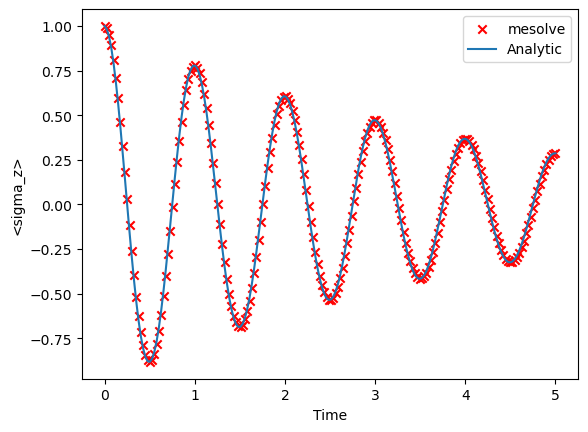

In [6]:
plt.scatter(tlist, res.expect[0], c="r", marker="x", label="mesolve")
plt.plot(tlist, sz_analytic, label="Analytic")
plt.xlabel("Time"), plt.ylabel("<sigma_z>")
plt.legend();

## Qubit Dynamics on the Bloch Sphere

We can also visualise the dynamics of the qubit state on the Bloch sphere. To generate more interesting plots, we consider slightly more complex dynamics of the qubit state.

Consider the following Hamiltonian: 

$H = \Delta ( \, cos(\theta) \, \sigma_z + sin(\theta) \, \sigma_x  \, )$.

In [10]:
delta = 2 * np.pi
# Angle
theta = 0.2 * np.pi

psi0 = basis(2, 0)

# Hamiltonian
H = delta * (np.cos(theta) * sigmaz() + np.sin(theta) * sigmax())

### Rotating State

$\theta$ defines the angle of the qubit state between the $z$-axis toward the $x$-axis. We can again use `mesolve` to obtain the dynamics of the system. Here, we pass an empty list of collapse operators.

In [11]:
# Obtain Time Evolution
tlist = np.linspace(0, 5, 500)
result = mesolve(H, psi0, tlist, []) #, [sigmax(), sigmay(), sigmaz()])

We can visualise the state on the Bloch sphere by using the `qutip.Bloch` class. We can add points to the Bloch sphere and also vectors representing states.

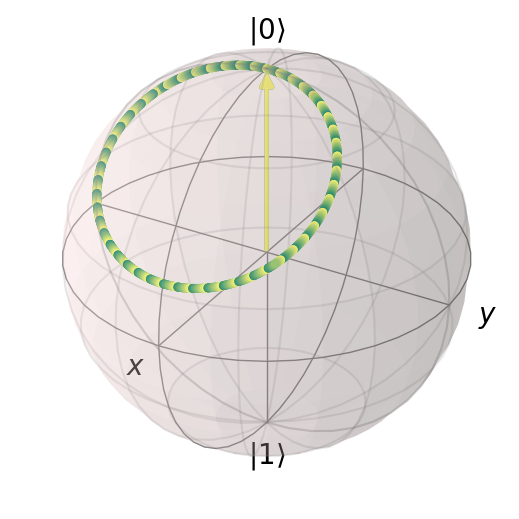

In [12]:
sphere = Bloch()
sphere.add_evolving_states(result.states)
sphere.show()

From the plot we can see the time-evolution of the initial state, which is a circular movement on the sphere's surface. As before, we add some collapse operators to the system, which alter the dynamics of the system. 

### Qubit dephasing

To change the phase of the qubit we introduce the following collapse operator:

$C = \sqrt{\gamma_p} \; \sigma_z$

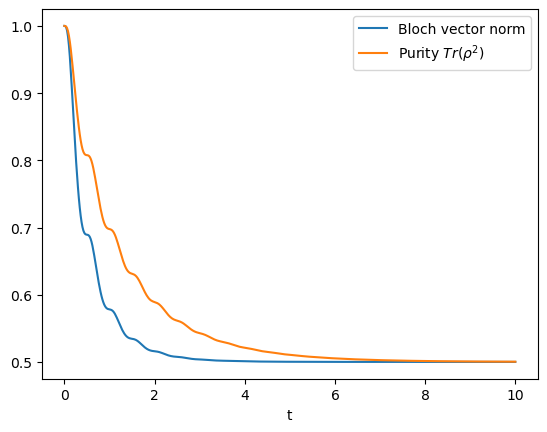

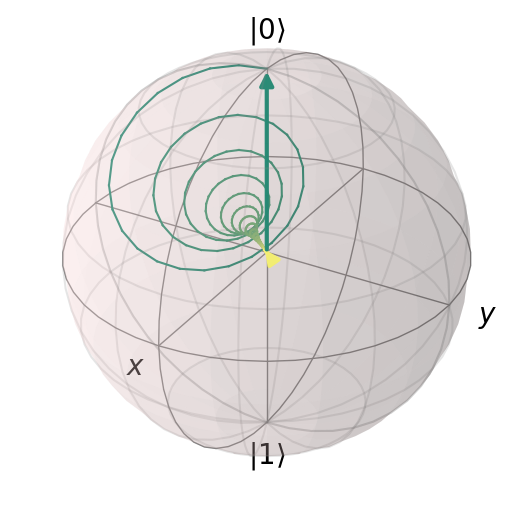

In [13]:
gamma_phase = 0.5
c_ops = [np.sqrt(gamma_phase) * sigmaz()]
tlist = np.linspace(0, 10, 500)

# solve dynamics
result = mesolve(H, psi0, tlist, c_ops) #, [sigmax(), sigmay(), sigmaz()])

# plot_ 1/2 norm^2+1(tlist, result.states)
norms = [bloch_norm(state) for state in result.states]
norms = np.array(norms)
plt.plot(tlist, (norms ** 2 + 1)/2, label='Bloch vector norm')

# plot_purity(tlist, result.states)
purities = [(r*r).tr() for r in result.states]
plt.plot(tlist, purities, label=r'Purity $Tr(\rho^2)$')
plt.xlabel('t')
plt.legend()
plt.show()

# Create Bloch sphere plot
sphere = Bloch()
sphere.add_evolving_states(result.states, kind='line')
sphere.show()

In [52]:
sphere = Bloch3d()
sphere.add_evolving_states(result.states, kind='point')
sphere.show()

We can observe the dephasing of the qubit by the decreasing radius of the qubit state movement.

### Qubit relaxation

Another type of dissipation we can explore is the relaxation of the qubit originating from the collapse operator

$C = \sqrt{\gamma_r} \sigma_-$

This induces spontaneous flips of the qubit from the excited state to the ground state with a rate $\gamma_r$. Again we can observe the qubit dynamics on the Bloch sphere.

#### Notes

> It seems that the pattern of the evolution of qubit is not so relavent to the initial state, rather to the Hamiltinian.
> 
> With $\sigma_-$ collapse operator:
> 
> - $H=\mathrm{Id}$, the state falls to $|1\rangle$.
> - $H=X$ or $H=Y$ or $H=X+Y$, it spins in the perpendicular plane to the Hamiltonian and spirals into a nearly maximally mixed state.
> - $H = \Delta ( \, cos(\theta) \, \sigma_z + sin(\theta) \, \sigma_x  \, )$, it goes spirally and diagonally.

In [1]:
gamma_relax = 0.5
c_ops = [np.sqrt(gamma_relax) * sigmam()]

tlist = np.linspace(0, 20, 50)

# solve dynamics
result = mesolve(H, psi0, tlist, c_ops)

# TRY...........................
# psix = 1/np.sqrt(2) * (basis(2, 0) + basis(2, 1))
# psiy = 1/np.sqrt(2) * (basis(2, 0) + 1j * basis(2, 1))
# psiz = basis(2, 0)
# # psi = 1/np.sqrt(3) * basis(2, 0) + 2/np.sqrt(3) * 
result = mesolve(sigmax()+sigmay(), psi0, tlist, c_ops)

plot_norm(tlist, result.states)

# Create Bloch sphere plot
sphere = Bloch()
sphere.add_evolving_states(result.states, kind='point', vector=False)
sphere.show()

NameError: name 'np' is not defined

In [67]:
# Create Bloch sphere plot
sphere = Bloch3d()
sphere.add_evolving_states(result.states, kind='point')
sphere.show()

Below is
$C = \sqrt{\gamma_r} \sigma_+$

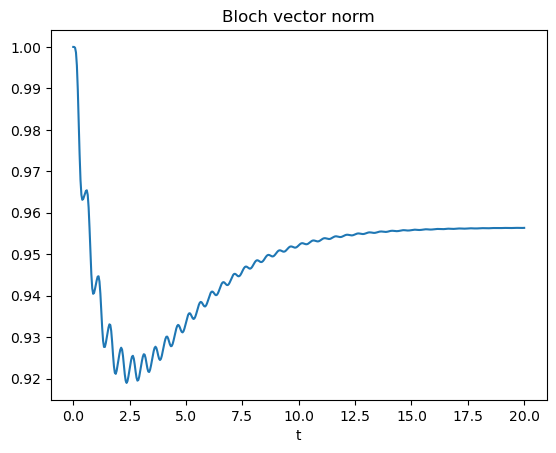

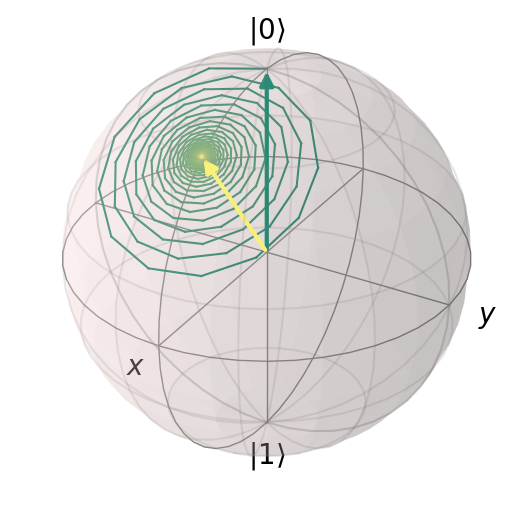

In [14]:
gamma_relax = 0.5
c_ops = [np.sqrt(gamma_relax) * sigmap()]

tlist = np.linspace(0, 20, 500)

# solve dynamics
result = mesolve(H, psi0, tlist, c_ops)

plot_norm(tlist, result.states)

# Create Bloch sphere plot
sphere = Bloch()
sphere.add_evolving_states(result.states, kind='line')
sphere.show()

In [ ]:
# Create Bloch sphere plot
sphere = Bloch3d()
sphere.add_evolving_states(result.states, kind='point')
sphere.show()

We can see how the circular trajectory shifts more to the ground state of the qubit. 

### Conclusion
Using the methods above, you can simulate any dissipative quantum system, whose dynamics are described by the master equation. Additionally you can make use of the methods to visualise the dynamics of a qubit state on the Bloch sphere.

## About

In [6]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.1
Numpy Version:      1.24.2
Scipy Version:      1.10.0
Cython Version:     None
Matplotlib Version: 3.6.3
Python Version:     3.9.16
Number of CPUs:     8
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  C:\ProgramData\miniconda3\envs\quantum\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily gene

### Testing

In [29]:
assert np.allclose(res.expect[0], sz_analytic, atol=0.05)
assert np.allclose(exp_sz_circ**2 + exp_sy_circ**2 + exp_sx_circ**2, 1.0)
assert np.all(
    np.diff(exp_sx_dephase**2 + exp_sy_dephase**2 + exp_sz_dephase**2) <= 0
)

NameError: name 'exp_sz_circ' is not defined